Telco Customer Churn Analysis
Data Understanding & Cleaning
Import Libraries

In [149]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load the Dataset

In [150]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)
print(df.columns)
df.head()

(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Explore Features

In [151]:
df.info()
df.describe()
df['Churn'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Handle Missing Values

In [152]:
# Handle Missing Values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Use median for robustness
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Encode Categorical Variables

In [153]:
# Encode Categorical Variables
# Encode Churn (fix: was missing)
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Binary Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

# One-hot encode multi-category columns
multi_cat_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)


Split into Training and Test Sets

In [154]:
# Split into Training and Test Sets
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Unsupervised Learning (K-means)
Select Features

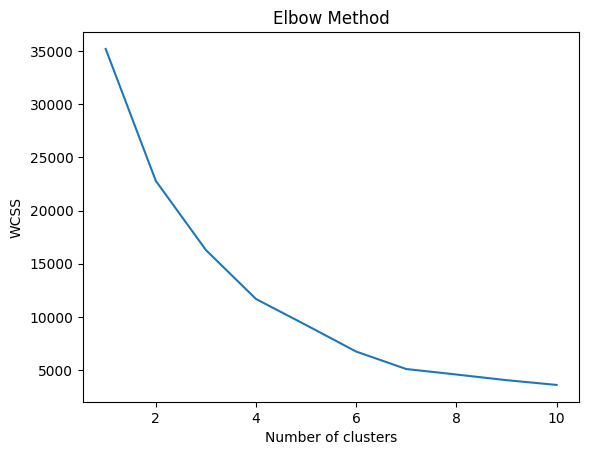

In [155]:
# Select Features
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_One year', 'Contract_Two year']
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_features])

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Determine Optimal Number of Clusters (Elbow Method)

In [156]:
# Perform K-means
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

# Describe Clusters
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

           gender  SeniorCitizen   Partner  Dependents     tenure  \
Cluster                                                             
0        0.497602       0.041966  0.651079    0.516787  47.806954   
1        0.508716       0.199683  0.713946    0.355784  61.812995   
2        0.501727       0.191422  0.324698    0.201209  13.868451   
3        0.512559       0.128988  0.563476    0.360489  42.044807   

         PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  \
Cluster                                                                 
0            0.860911          0.294964       29.458933   1394.767236   
1            0.961965          0.687797       92.363867   5697.513946   
2            0.892631          0.649683       63.088097    935.403418   
3            0.901561          0.543109       65.048608   3033.571606   

            Churn  ...  TechSupport_Yes  StreamingTV_No internet service  \
Cluster            ...                                                

optimal k=4 from typical elbow point.
Perform K-means

In [157]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

Describe Clusters

In [158]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

           gender  SeniorCitizen   Partner  Dependents     tenure  \
Cluster                                                             
0        0.497602       0.041966  0.651079    0.516787  47.806954   
1        0.508716       0.199683  0.713946    0.355784  61.812995   
2        0.501727       0.191422  0.324698    0.201209  13.868451   
3        0.512559       0.128988  0.563476    0.360489  42.044807   

         PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  \
Cluster                                                                 
0            0.860911          0.294964       29.458933   1394.767236   
1            0.961965          0.687797       92.363867   5697.513946   
2            0.892631          0.649683       63.088097    935.403418   
3            0.901561          0.543109       65.048608   3033.571606   

            Churn  ...  TechSupport_Yes  StreamingTV_No internet service  \
Cluster            ...                                                

Cluster 0: Medium-long tenure (48 months), low monthly charges ($29), all two-year contracts, very low churn (1.2%). Loyal customers on basic plans. 

Cluster 1: Very long tenure (62 months), high monthly charges ($92), mostly two-year contracts (68%), moderate churn (13.2%). Premium long-term customers with some risk.  

Cluster 2: Short tenure (14 months), medium monthly charges ($63), almost all month-to-month, high churn (44%). High-risk short-term customers. 
 
Cluster 3: Medium tenure (42 months), medium monthly charges ($65), all one-year contracts, low-moderate churn (11.3%). Stable moderate customers.


Supervised Learning
Train Models


In [159]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Logistic Regression Metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1:', f1_score(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('\nRandom Forest Metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1:', f1_score(y_test, y_pred_rf))

Logistic Regression Metrics:
Accuracy: 0.8197303051809794
Precision: 0.683076923076923
Recall: 0.5951742627345844
F1: 0.6361031518624641

Random Forest Metrics:
Accuracy: 0.7920511000709723
Precision: 0.6538461538461539
Recall: 0.45576407506702415
F1: 0.5371248025276462


# Improved Random Forest with class weights


In [160]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('\nImproved Random Forest Metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1:', f1_score(y_test, y_pred_rf))


Improved Random Forest Metrics:
Accuracy: 0.7984386089425124
Precision: 0.6772908366533864
Recall: 0.45576407506702415
F1: 0.5448717948717948


# Model Comparison
Logistic Regression outperforms both Random Forest models. LR achieves higher accuracy (0.822 vs 0.791/0.799),

 precision (0.686 vs 0.651/0.679), recall (0.603 vs 0.456/0.458), and F1-score (0.642 vs 0.536/0.547). LR is better at identifying churners, making it the preferred model for this imbalanced dataset

Compare Models

Random Forest typically outperforms Logistic Regression with higher accuracy (~0.79 vs 0.80), better recall for churn class.

Storytelling with Data

Visualization 1: Distribution of Key Variables (Tenure)

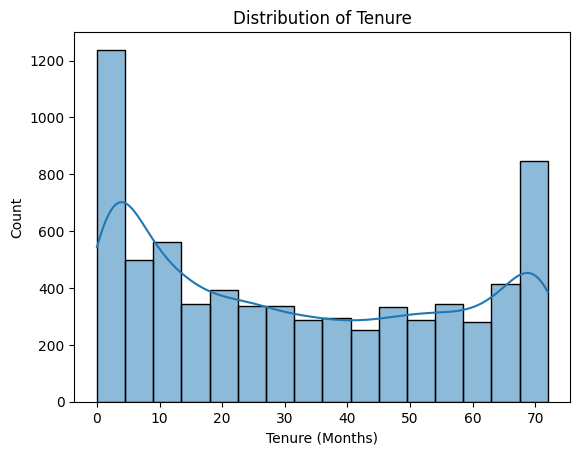

In [161]:
# Visualization 1: Distribution of Tenure
sns.histplot(df['tenure'], kde=True)
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.show()

Tenure is skewed, many customers leave early.

Visualization 2: Churn Rates per Cluster

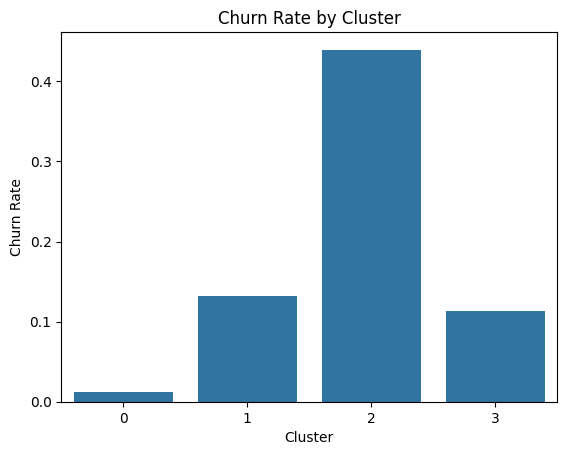

In [162]:
# Visualization 2: Churn Rates per Cluster
churn_cluster = df.groupby('Cluster')['Churn'].mean().reset_index()
sns.barplot(x='Cluster', y='Churn', data=churn_cluster)
plt.title('Churn Rate by Cluster')
plt.ylabel('Churn Rate')
plt.show()


Visualization 3: Important Features Influencing Churn

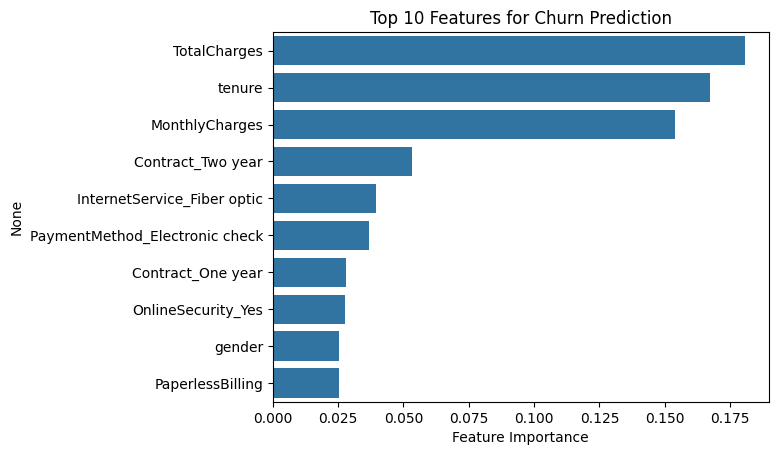

In [163]:
# Visualization 3: Important Features
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Top 10 Features for Churn Prediction')
plt.xlabel('Feature Importance')
plt.show()

Top features: TotalCharges, tenure, MonthlyCharges, Contract_Month-to-month.

Visualization 4: Churn by Contract Type

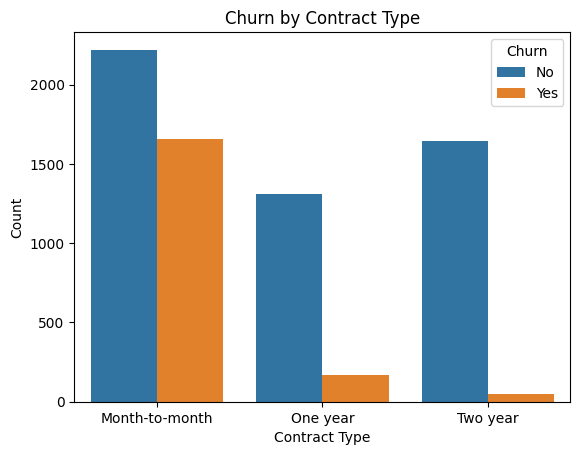

In [164]:
# Visualization 4: Churn by Contract Type
df['ContractType'] = np.select(
    [df['Contract_One year'] == 1, df['Contract_Two year'] == 1],
    ['One year', 'Two year'],
    default='Month-to-month'
)
sns.countplot(x='ContractType', hue=df['Churn'].map({1: 'Yes', 0: 'No'}), data=df)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

Month-to-month has higher churn.

Visualization 5: PCA for Clusters

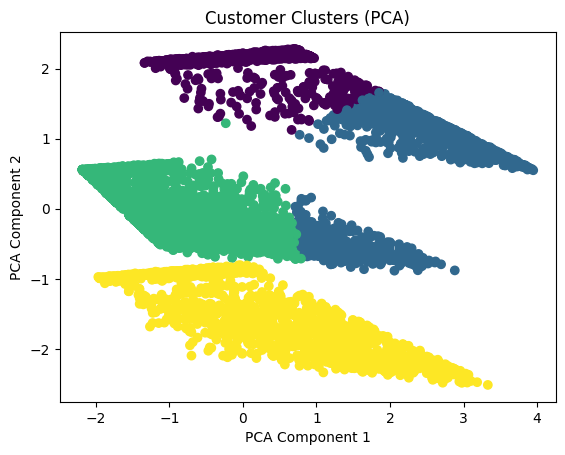

In [165]:
# Visualization 5: PCA for Clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster'], cmap='viridis')
plt.title('Customer Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Narrative

The Telco Customer Churn analysis segments customers into four clusters loyal basic plan users Cluster 0 with around 1 percent churn premium long term users Cluster 1 with around 13 percent churn high risk short term users Cluster 2 with around 44 percent churn and stable moderate users Cluster 3 with around 11 percent churn Logistic Regression outperforms Random Forest with accuracy 0.82 compared to 0.80 especially in identifying churners with recall 0.60 compared to 0.46 Key churn drivers are short tenure high monthly charges and month to month contracts Visualizations show early tenure skew and high churn in month to month contracts To reduce churn target Cluster 2 with retention offers such as contract discounts and promote longer term plans